## Goal Statement:

The goal of this project is to build a working prediction model that can take a GitHub repo's Readme file. Then using NLP predict the primary programming langauge of that repo. 


The end product will be a function that can take in a readme file, and spit out the predicted language

In [1]:
import pandas as pd

### Step 1: Acquire the data. 
This CSV was generated using the prepare.read_lang() function in conjuction with a list of URLs provided from the prepare.get_all_links() function. 
It was saved to CSV for the sake saving Bandwith from github. They have enough people hitting their servers, so it's best to acquire once, and read localally. 

In [2]:
df = pd.read_csv('readmes.csv').rename(columns = {'Unnamed: 0': 'Repository'}).set_index('Repository')

Now let's take a quick peak at the data we are working with 

In [3]:
df.shape

(325, 2)

In [4]:
df.head()

,language,readme
Repository,,
iluwatar/java-design-patterns,Java,Design patterns implemented in Java Introducti...
elastic/elasticsearch,Java,Elasticsearch A Distributed RESTful Search Eng...
Snailclimb/JavaGuide,Java,点击订阅Java面试进阶指南(专为Java面试方向准备)。为什么要弄这个专栏? Specia...
ReactiveX/RxJava,Java,RxJava: Reactive Extensions for the JVM RxJava...
spring-projects/spring-boot,Java,Spring Boot Spring Boot makes it easy to creat...


In [5]:
df.isnull().sum()

language    0
readme      2
dtype: int64

Looks like 2 of our repos are missing readmes. Let's go ahead and drop those two instances with a drop na

In [6]:
df.dropna(inplace=True)

If we look at .head() from before, we can also see that some of our results are not in English.
To help fix that we can use google's detect language. If you don't already have that installed, it can be installed with a quick pip install

``` pip install langdetect ```

In [7]:
from langdetect import detect

In [8]:
print(detect('gatos y perros'))
print(detect('My name is Norrick!'))
print(type(detect('this will tell me the return type of detect')))

es
en
<class 'str'>


In [9]:
len([readme for readme in df.readme if detect(readme) == 'en'])

310

If we excluded our readmes we still have a decent amount of info to work with 
let's take a look at what other languages we have in there besides english.

(list of ISO 639 language codes can be found [here](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes) )

In [10]:
[detect(readme) for readme in df.readme if detect(readme) != 'en']

['zh-cn',
 'no',
 'zh-cn',
 'zh-cn',
 'zh-cn',
 'vi',
 'en',
 'no',
 'tl',
 'zh-cn',
 'vi',
 'vi',
 'zh-cn',
 'no']

Looks like Norweigen and Chinese tend to be the biggest results right along side Vietnamese. 
Let's go ahead and remove non-english entries from our DataFrame

In [11]:
df['lang_code'] = [detect(readme) for readme in df.readme]

In [12]:
df = df[df['lang_code'] == 'en'].drop(columns='lang_code')

In [13]:
df.shape

(310, 2)

Now that we've take care of that portion of readmes, let's look at cleaning up the rest of the data
We've built some prebuilt functions that take care of the majority of the house keeping using regular expressions and stemming

In [14]:
import prepare

In [16]:
df['cleaned'] = [prepare.deep_clean(readme) for readme in df.readme]

In [17]:
df

,language,readme,cleaned
Repository,,,
iluwatar/java-design-patterns,Java,Design patterns implemented in Java Introducti...,design pattern implement introduct design patt...
elastic/elasticsearch,Java,Elasticsearch A Distributed RESTful Search Eng...,elasticsearch distribut rest search engin elas...
ReactiveX/RxJava,Java,RxJava: Reactive Extensions for the JVM RxJava...,rxjava reactiv extens jvm rxjava vm implement ...
spring-projects/spring-boot,Java,Spring Boot Spring Boot makes it easy to creat...,spring boot spring boot make easi creat spring...
kdn251/interviews,Java,Interviews Your personal guide to Software Eng...,interview person guid softwar engin technic in...
square/retrofit,Java,Retrofit Type-safe HTTP client for Android and...,retrofit typesaf http client android squar inc...
square/okhttp,Java,OkHttp An HTTP & HTTP/2 client for Android and...,okhttp http http client android applic inform ...
google/guava,Java,Guava: Google Core Libraries for Java Guava is...,guava googl core librari guava set core librar...
PhilJay/MPAndroidChart,Java,⚡️ A powerful & easy to use chart library for ...,power easi use chart librari android chart io ...


Now that we have some cleaner readmes to work with, let's go ahead and start diving into the Data

In [26]:
import nltk
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def n_gram_series(series, n):
    return pd.Series(nltk.ngrams(''.join(series).split(), n)).value_counts()

def generate_freq_for_cloud(ngram_valuecount):
    return {' '.join(k): v for k, v in ngram_valuecount.to_dict().items()}

def wordcloud_img_from_ngram(series,n,width=400,height=400):
    ngram_series = n_gram_series(series,n)
    freq = generate_freq_for_cloud(ngram_series)
    return WordCloud(background_color='white', width=width, height=height).generate_from_frequencies(freq)

In [35]:
img = wordcloud_img_from_ngram(df[df['language']=='Java'].cleaned,2,height=800,width=800)

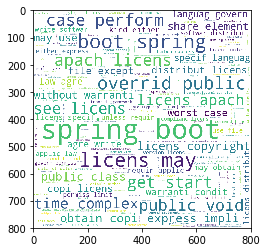

In [36]:
plt.figure(figsize=(8,4))
plt.imshow(img)